# Энричмент
### Макарова Ирина
### 2022

* Определение генов, которые имеют разный уровень экспрессии в норме и раке. 
* Состав пасвеев (KEGG или GO), используя ресурс MSigDB. Реализуйте простой анализ перепредставленности, используя как вход дифференциально экспрессированные гены. Сравнение с результатами WebGestaldt.<br>

In [1]:
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
import statsmodels.api as sm
import statsmodels.stats.multitest as multi

### 0. Данные

In [3]:
#данные по экспрессии
expr = pd.read_csv('expr.tsv', sep='\t')
expr

,GSM588828,GSM588829,GSM588830,GSM588831,GSM588832,GSM588833,GSM588834,GSM588835,GSM588836,GSM588837,...,GSM588877,GSM588878,GSM588879,GSM588880,GSM588881,GSM588882,GSM588883,GSM588884,GSM588885,GSM588886
0,4.133779,4.195093,3.981460,4.397206,4.111491,4.322267,4.702411,4.343087,4.580750,4.179001,...,3.870638,4.540533,4.309905,4.519285,4.427059,4.587475,4.498123,4.281139,4.498443,4.228814
1,6.928043,5.790547,7.176388,5.023986,5.062291,7.733216,7.103563,6.888509,2.011922,7.510507,...,8.519612,7.397365,6.637553,7.680953,5.821583,7.955098,6.002558,7.053275,7.511692,8.109734
2,5.436122,4.778579,5.938665,6.540153,5.498697,5.887690,5.434566,4.686246,5.599699,5.380077,...,4.394201,4.487075,5.514207,5.681542,5.054774,4.673883,4.518913,4.425299,4.200812,4.001112
3,2.892430,1.663153,3.485304,2.837845,2.524734,3.412039,3.892142,3.220816,4.108645,3.365574,...,3.200994,3.599084,4.684521,3.937642,5.984184,4.305265,5.793236,3.611910,4.158352,3.779648
4,3.340189,3.238030,2.398587,0.860390,3.680071,2.235755,4.304426,3.044746,4.451681,4.166952,...,3.735891,3.091286,4.757382,4.752151,4.520755,1.338718,3.762129,3.974924,4.091977,3.096955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19751,5.792419,6.871523,4.415222,4.976440,6.890685,5.138895,4.707830,5.741029,6.339338,5.037506,...,5.565392,4.209778,4.949108,5.201290,2.441260,3.472746,4.193778,5.815519,6.187848,4.389519
19752,3.492174,3.172782,3.543622,3.551962,3.399357,3.064259,3.326167,3.477962,4.212650,3.300507,...,4.155240,3.760613,3.185808,3.763062,3.414398,3.365574,3.311835,3.691245,4.092546,3.330734
19753,7.585989,7.173896,8.819087,8.224931,7.798504,8.083713,8.582376,8.070683,7.718270,7.810143,...,7.898544,8.380588,7.988952,7.852746,8.274925,8.558271,7.884784,8.361871,8.567435,8.539417
19754,3.222724,2.955308,0.567298,3.796749,2.539163,3.547587,2.051359,3.096646,3.284194,3.401253,...,2.098201,1.842656,1.909917,1.958024,3.976918,2.870508,2.064487,3.123625,2.812270,1.877828


In [4]:
#19,756 генов
genes = pd.read_csv('genes.tsv', sep='\t')
genes

,ID,GB_ACC,SPOT_ID,Species Scientific Name,Annotation Date,Sequence Type,Sequence Source,Target Description,Representative Public ID,Gene Title,Gene Symbol,ENTREZ_GENE_ID,RefSeq Transcript ID,Gene Ontology Biological Process,Gene Ontology Cellular Component,Gene Ontology Molecular Function
0,229819_at,AI022193,NaN,Homo sapiens,"Oct 6, 2014",Consensus sequence,GenBank,gb:AI022193 /DB_XREF=gi:3239546 /DB_XREF=ow92f...,AI022193,alpha-1-B glycoprotein,A1BG,1,NM_130786,NaN,0005576 // extracellular region // inferred fr...,0005515 // protein binding // inferred from el...
1,206797_at,NM_000015,NaN,Homo sapiens,"Oct 6, 2014",Exemplar sequence,GenBank,gb:NM_000015.1 /DB_XREF=gi:4557782 /GEN=NAT2 /...,NM_000015,N-acetyltransferase 2 (arylamine N-acetyltrans...,NAT2,10,NM_000015,0006805 // xenobiotic metabolic process // tra...,0005737 // cytoplasm // inferred from electron...,0004060 // arylamine N-acetyltransferase activ...
2,204639_at,NM_000022,NaN,Homo sapiens,"Oct 6, 2014",Exemplar sequence,GenBank,gb:NM_000022.1 /DB_XREF=gi:4557248 /GEN=ADA /F...,NM_000022,adenosine deaminase,ADA,100,NM_000022 /// XM_005260236 /// XM_006723679 //...,0001666 // response to hypoxia // inferred fro...,0005615 // extracellular space // inferred fro...,0001883 // purine nucleoside binding // inferr...
3,203440_at,M34064,NaN,Homo sapiens,"Oct 6, 2014",Exemplar sequence,GenBank,gb:M34064.1 /DB_XREF=gi:416292 /GEN=NCAD /FEA=...,M34064,"cadherin 2, type 1, N-cadherin (neuronal)",CDH2,1000,NM_001792 /// XM_005258181 /// XM_005258182,0007155 // cell adhesion // traceable author s...,0005886 // plasma membrane // traceable author...,0005509 // calcium ion binding // inferred fro...
4,222880_at,AF135794,NaN,Homo sapiens,"Oct 6, 2014",Exemplar sequence,GenBank,gb:AF135794.1 /DB_XREF=gi:4574743 /FEA=FLmRNA ...,AF135794,v-akt murine thymoma viral oncogene homolog 3,AKT3,10000,NM_001206729 /// NM_005465 /// NM_181690 /// X...,0000002 // mitochondrial genome maintenance //...,0005634 // nucleus // inferred from direct ass...,0000166 // nucleotide binding // inferred from...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19751,207223_s_at,NM_005156,NaN,Homo sapiens,"Oct 6, 2014",Exemplar sequence,GenBank,gb:NM_005156.1 /DB_XREF=gi:4826983 /GEN=ROD1 /...,NM_005156,polypyrimidine tract binding protein 3,PTBP3,9991,NM_001163788 /// NM_001163790 /// NM_001244896...,0006397 // mRNA processing // inferred from el...,0005634 // nucleus // inferred from electronic...,0000166 // nucleotide binding // inferred from...
19752,221095_s_at,NM_005136,NaN,Homo sapiens,"Oct 6, 2014",Exemplar sequence,GenBank,gb:NM_005136.1 /DB_XREF=gi:4826795 /GEN=KCNE2 ...,NM_005136,"potassium voltage-gated channel, Isk-related f...",KCNE2,9992,NM_172201,0006810 // transport // inferred from electron...,0005764 // lysosome // inferred from direct as...,0005242 // inward rectifier potassium channel ...
19753,214198_s_at,AU150824,NaN,Homo sapiens,"Oct 6, 2014",Consensus sequence,GenBank,gb:AU150824 /DB_XREF=gi:11012345 /DB_XREF=AU15...,AU150824,DiGeorge syndrome critical region gene 2,DGCR2,9993,NM_001173533 /// NM_001173534 /// NM_001184781...,0007155 // cell adhesion // inferred from elec...,0016020 // membrane // inferred from electroni...,0005515 // protein binding // inferred from el...
19754,1570001_at,BC027850,NaN,Homo sapiens,"Oct 6, 2014",Consensus sequence,GenBank,gb:BC027850.1 /DB_XREF=gi:24081029 /TID=Hs2.40...,BC027850,caspase 8 associated protein 2,CASP8AP2,9994,NM_001137667 /// NM_001137668 /// NM_012115,"0006351 // transcription, DNA-templated // inf...",0005634 // nucleus // inferred from direct ass...,0003677 // DNA binding // inferred from electr...


In [5]:
#58 образцов
anno = pd.read_csv('anno.tsv', sep='\t')
anno

,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,characteristics_ch1,...,contact_department,contact_institute,contact_address,contact_city,contact_state,contact_zip/postal_code,contact_country,supplementary_file,data_row_count,gender:ch1
0,CC2,GSM588828,Public on Aug 31 2010,Aug 30 2010,Aug 30 2010,RNA,1,colon tumour,Homo sapiens,gender: Male,...,HUMAN CANCER GENOMIC,KING FAISAL SPECIALIST HOSPITAL & RESEARCH CENTER,"MBC 98-16, PO BOX 3354",RIYADH 11211,KSA,11211,Saudi Arabia,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM588n...,54675,Male
1,CC3,GSM588829,Public on Aug 31 2010,Aug 30 2010,Aug 30 2010,RNA,1,colon tumour,Homo sapiens,gender: Male,...,HUMAN CANCER GENOMIC,KING FAISAL SPECIALIST HOSPITAL & RESEARCH CENTER,"MBC 98-16, PO BOX 3354",RIYADH 11211,KSA,11211,Saudi Arabia,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM588n...,54675,Male
2,CC6,GSM588830,Public on Aug 31 2010,Aug 30 2010,Aug 30 2010,RNA,1,colon tumour,Homo sapiens,gender: Male,...,HUMAN CANCER GENOMIC,KING FAISAL SPECIALIST HOSPITAL & RESEARCH CENTER,"MBC 98-16, PO BOX 3354",RIYADH 11211,KSA,11211,Saudi Arabia,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM588n...,54675,Male
3,CC8,GSM588831,Public on Aug 31 2010,Aug 30 2010,Aug 30 2010,RNA,1,colon tumour,Homo sapiens,gender: Male,...,HUMAN CANCER GENOMIC,KING FAISAL SPECIALIST HOSPITAL & RESEARCH CENTER,"MBC 98-16, PO BOX 3354",RIYADH 11211,KSA,11211,Saudi Arabia,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM588n...,54675,Male
4,CC11,GSM588832,Public on Aug 31 2010,Aug 30 2010,Aug 30 2010,RNA,1,colon tumour,Homo sapiens,gender: Female,...,HUMAN CANCER GENOMIC,KING FAISAL SPECIALIST HOSPITAL & RESEARCH CENTER,"MBC 98-16, PO BOX 3354",RIYADH 11211,KSA,11211,Saudi Arabia,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM588n...,54675,Female
5,CC12,GSM588833,Public on Aug 31 2010,Aug 30 2010,Aug 30 2010,RNA,1,colon tumour,Homo sapiens,gender: Female,...,HUMAN CANCER GENOMIC,KING FAISAL SPECIALIST HOSPITAL & RESEARCH CENTER,"MBC 98-16, PO BOX 3354",RIYADH 11211,KSA,11211,Saudi Arabia,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM588n...,54675,Female
6,CC13,GSM588834,Public on Aug 31 2010,Aug 30 2010,Aug 30 2010,RNA,1,colon tumour,Homo sapiens,gender: Female,...,HUMAN CANCER GENOMIC,KING FAISAL SPECIALIST HOSPITAL & RESEARCH CENTER,"MBC 98-16, PO BOX 3354",RIYADH 11211,KSA,11211,Saudi Arabia,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM588n...,54675,Female
7,CC16,GSM588835,Public on Aug 31 2010,Aug 30 2010,Aug 30 2010,RNA,1,colon tumour,Homo sapiens,gender: Female,...,HUMAN CANCER GENOMIC,KING FAISAL SPECIALIST HOSPITAL & RESEARCH CENTER,"MBC 98-16, PO BOX 3354",RIYADH 11211,KSA,11211,Saudi Arabia,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM588n...,54675,Female
8,CC17,GSM588836,Public on Aug 31 2010,Aug 30 2010,Aug 30 2010,RNA,1,colon tumour,Homo sapiens,gender: Male,...,HUMAN CANCER GENOMIC,KING FAISAL SPECIALIST HOSPITAL & RESEARCH CENTER,"MBC 98-16, PO BOX 3354",RIYADH 11211,KSA,11211,Saudi Arabia,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM588n...,54675,Male
9,CC18,GSM588837,Public on Aug 31 2010,Aug 30 2010,Aug 30 2010,RNA,1,colon tumour,Homo sapiens,gender: Male,...,HUMAN CANCER GENOMIC,KING FAISAL SPECIALIST HOSPITAL & RESEARCH CENTER,"MBC 98-16, PO BOX 3354",RIYADH 11211,KSA,11211,Saudi Arabia,ftp://ftp.ncbi.nlm.nih.gov/geo/samples/GSM588n...,54675,Male


In [6]:
anno.source_name_ch1.describe() #всего 2 уникальных значения: tumour / norm

count               58
unique               2
top       colon tumour
freq                34
Name: source_name_ch1, dtype: object

In [7]:
annot = anno[['geo_accession','source_name_ch1']].copy().set_index('geo_accession').T
annot

geo_accession,GSM588828,GSM588829,GSM588830,GSM588831,GSM588832,GSM588833,GSM588834,GSM588835,GSM588836,GSM588837,...,GSM588877,GSM588878,GSM588879,GSM588880,GSM588881,GSM588882,GSM588883,GSM588884,GSM588885,GSM588886
source_name_ch1,colon tumour,colon tumour,colon tumour,colon tumour,colon tumour,colon tumour,colon tumour,colon tumour,colon tumour,colon tumour,...,normal paired tissue,normal paired tissue,normal paired tissue,normal paired tissue,normal paired tissue,normal paired tissue,normal paired tissue,normal paired tissue,normal paired tissue,normal paired tissue


### 1. Образцы
Постройте график ящик-с-усами (boxplot) для каждого образца (можно его раскрасить по типу образца) чтобы убедится в отсутствии необходимости дополнительной нормализации.

C:\Users\Irina Makarova\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


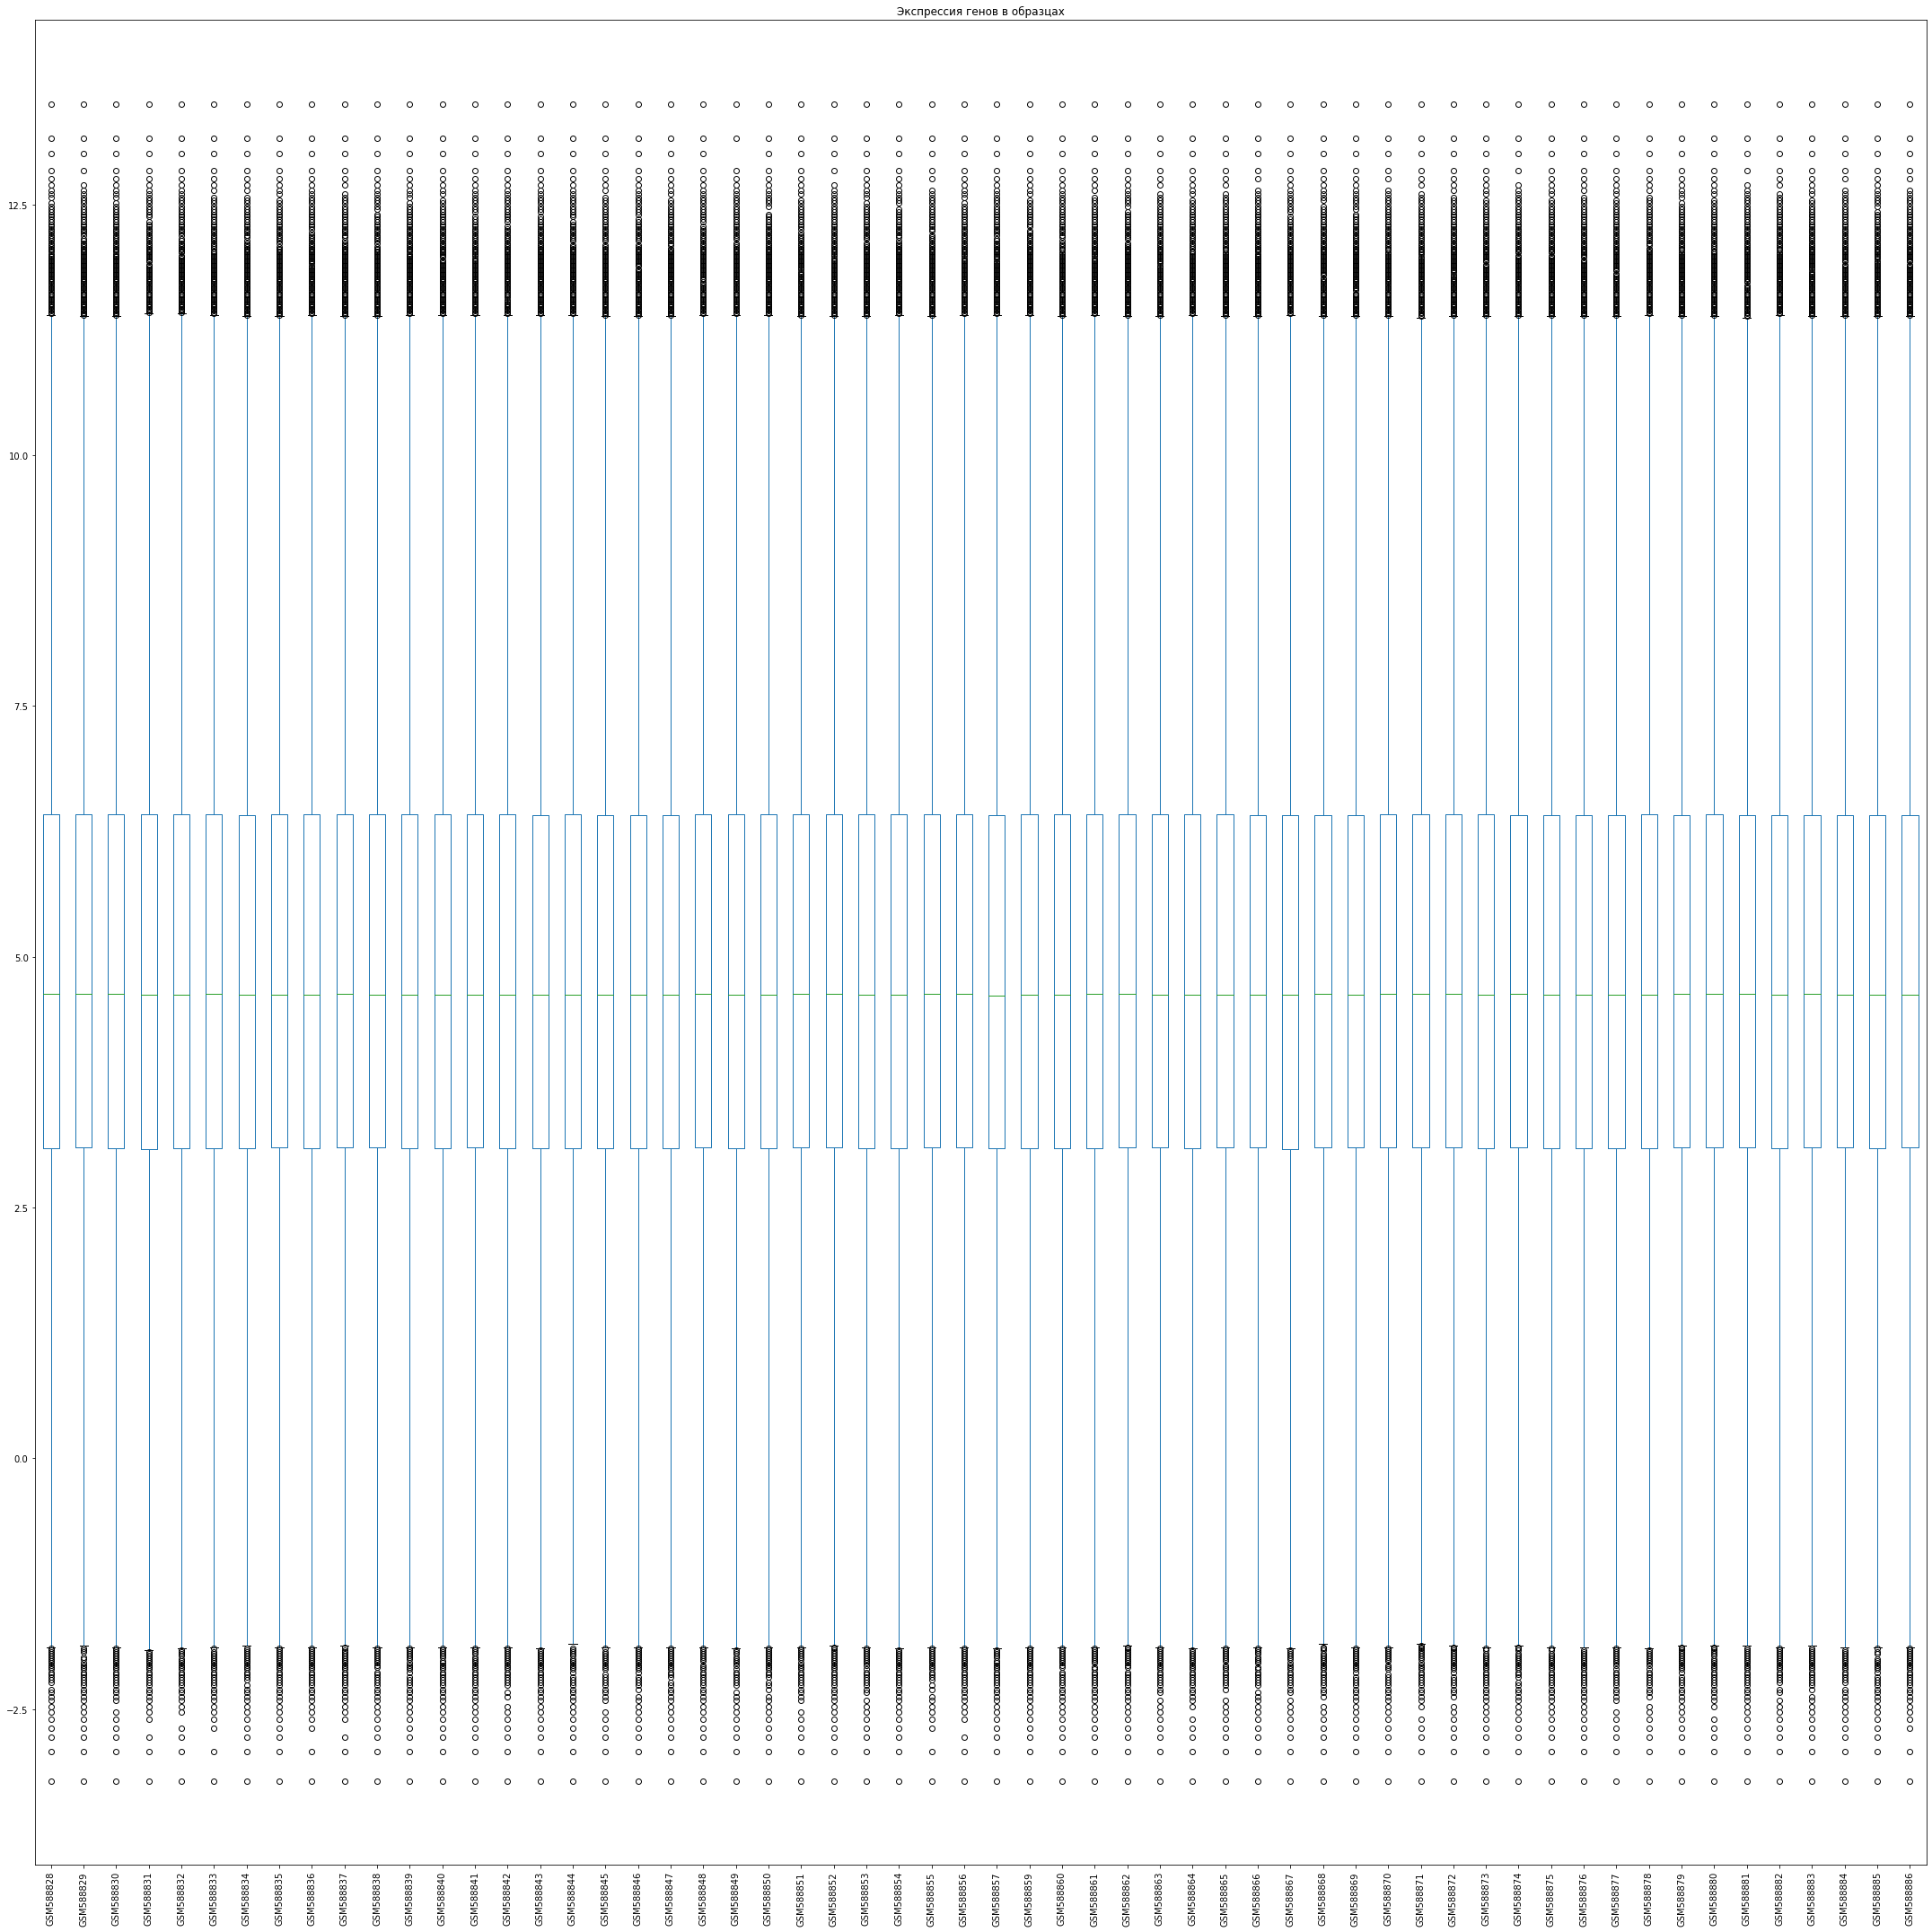

In [9]:
plt.rcParams["figure.figsize"] = [30, 30]
plt.rcParams["figure.autolayout"] = True
ax = expr.plot(kind='box', 
               title='Экспрессия генов в образцах')
plt.xticks(rotation=90)
plt.show()

На основании сырых данных тоже видно, что средняя экспрессия генов приблизительно одинаковая для всех образцов (аналогично для std).

In [10]:
expr.describe()

,GSM588828,GSM588829,GSM588830,GSM588831,GSM588832,GSM588833,GSM588834,GSM588835,GSM588836,GSM588837,...,GSM588877,GSM588878,GSM588879,GSM588880,GSM588881,GSM588882,GSM588883,GSM588884,GSM588885,GSM588886
count,19756.000000,19756.000000,19756.000000,19756.000000,19756.000000,19756.000000,19756.000000,19756.000000,19756.000000,19756.000000,...,19756.000000,19756.000000,19756.000000,19756.000000,19756.000000,19756.000000,19756.000000,19756.000000,19756.000000,19756.000000
mean,4.752850,4.752206,4.752026,4.748962,4.750058,4.752024,4.750817,4.752486,4.751049,4.752509,...,4.750645,4.750177,4.753735,4.754329,4.754055,4.749907,4.753255,4.752195,4.752510,4.752235
std,2.423383,2.423754,2.424067,2.426017,2.426854,2.424450,2.425045,2.423422,2.426788,2.424904,...,2.424562,2.424278,2.422635,2.423670,2.421280,2.424745,2.422518,2.423259,2.422873,2.424017
min,-3.217046,-3.217046,-3.217046,-3.217046,-3.217046,-3.217046,-3.217046,-3.217046,-3.217046,-3.217046,...,-3.217046,-3.217046,-3.217046,-3.217046,-3.217046,-3.217046,-3.217046,-3.217046,-3.217046,-3.217046
25%,3.094326,3.096878,3.095914,3.084589,3.089513,3.095257,3.094931,3.096559,3.092879,3.099702,...,3.094931,3.091514,3.101130,3.100086,3.100086,3.091514,3.098523,3.096559,3.094326,3.096878
50%,4.628601,4.627054,4.627392,4.624453,4.624762,4.627675,4.624453,4.625432,4.626091,4.628908,...,4.623211,4.623211,4.628314,4.628601,4.629551,4.621763,4.628601,4.625432,4.624134,4.625774
75%,6.418021,6.416307,6.416307,6.417115,6.418796,6.418021,6.413735,6.418021,6.418430,6.416720,...,6.414539,6.416307,6.415423,6.418430,6.414539,6.415909,6.414133,6.415423,6.415423,6.415909
max,13.500689,13.500689,13.500689,13.500689,13.500689,13.500689,13.500689,13.500689,13.500689,13.500689,...,13.500689,13.500689,13.500689,13.500689,13.500689,13.500689,13.500689,13.500689,13.500689,13.500689


Видно, что дополнительная нормализация не нужна, данные разных образцов сопоставимы.

### 2. Экспрессия
Найдите гены которые имеют разный уровень экспрессии в норме и раке. <br>
Экспрессия скольких генов статистически достоверно различается между раком и нормой?

Данные по раку:

In [8]:
tum = expr.copy()
norm = expr.copy()
for col in expr.columns:
    if annot.loc['source_name_ch1', col] == 'colon tumour':
        norm.drop(col, 'columns', inplace=True)
    elif annot.loc['source_name_ch1', col] == 'normal paired tissue':
        tum.drop(col, 'columns', inplace=True)

In [9]:
tum

,GSM588828,GSM588829,GSM588830,GSM588831,GSM588832,GSM588833,GSM588834,GSM588835,GSM588836,GSM588837,...,GSM588852,GSM588853,GSM588854,GSM588855,GSM588856,GSM588857,GSM588859,GSM588860,GSM588861,GSM588862
0,4.133779,4.195093,3.981460,4.397206,4.111491,4.322267,4.702411,4.343087,4.580750,4.179001,...,5.038639,4.135071,4.631120,4.479703,4.909199,5.370284,4.769031,5.252268,4.047339,4.356666
1,6.928043,5.790547,7.176388,5.023986,5.062291,7.733216,7.103563,6.888509,2.011922,7.510507,...,5.126306,6.324782,5.293779,5.312008,5.174893,3.032131,5.257093,4.963604,5.320970,4.401618
2,5.436122,4.778579,5.938665,6.540153,5.498697,5.887690,5.434566,4.686246,5.599699,5.380077,...,5.643965,4.943403,6.562112,4.544076,4.952698,6.888111,6.057377,6.205238,6.508784,5.657585
3,2.892430,1.663153,3.485304,2.837845,2.524734,3.412039,3.892142,3.220816,4.108645,3.365574,...,4.095495,3.038003,3.926705,4.860407,5.444193,5.321717,4.695463,3.239573,3.421516,3.509513
4,3.340189,3.238030,2.398587,0.860390,3.680071,2.235755,4.304426,3.044746,4.451681,4.166952,...,4.808583,2.924547,4.303223,5.070016,4.856971,1.737824,2.596573,2.023505,3.057611,3.406958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19751,5.792419,6.871523,4.415222,4.976440,6.890685,5.138895,4.707830,5.741029,6.339338,5.037506,...,6.207064,5.597423,5.848031,6.139888,6.042241,4.250225,3.945981,4.168686,7.038432,5.159771
19752,3.492174,3.172782,3.543622,3.551962,3.399357,3.064259,3.326167,3.477962,4.212650,3.300507,...,3.478197,3.916382,2.890686,3.473911,3.874801,3.835092,3.198002,3.973829,3.309828,2.853086
19753,7.585989,7.173896,8.819087,8.224931,7.798504,8.083713,8.582376,8.070683,7.718270,7.810143,...,7.531280,6.953233,7.814872,7.510018,7.730817,9.981630,7.975710,8.829444,7.297188,8.118886
19754,3.222724,2.955308,0.567298,3.796749,2.539163,3.547587,2.051359,3.096646,3.284194,3.401253,...,3.181708,1.997572,2.762135,2.811510,2.987774,2.783489,3.536327,2.114032,3.071889,1.831598


Данные по норме:

In [10]:
norm

,GSM588863,GSM588864,GSM588865,GSM588866,GSM588867,GSM588868,GSM588869,GSM588870,GSM588871,GSM588872,...,GSM588877,GSM588878,GSM588879,GSM588880,GSM588881,GSM588882,GSM588883,GSM588884,GSM588885,GSM588886
0,4.516112,4.797943,4.598403,4.572516,5.571188,4.571001,4.811720,4.813395,4.522189,4.967473,...,3.870638,4.540533,4.309905,4.519285,4.427059,4.587475,4.498123,4.281139,4.498443,4.228814
1,7.674473,8.083713,8.786125,8.539417,9.680852,7.961447,8.463590,7.850695,6.017464,6.510709,...,8.519612,7.397365,6.637553,7.680953,5.821583,7.955098,6.002558,7.053275,7.511692,8.109734
2,5.430750,4.951026,5.441362,5.555896,4.499013,5.987317,4.740167,5.344184,6.027013,6.913990,...,4.394201,4.487075,5.514207,5.681542,5.054774,4.673883,4.518913,4.425299,4.200812,4.001112
3,4.287606,2.891382,3.745011,3.723018,4.051075,3.885954,4.284779,4.085956,5.028645,6.402642,...,3.200994,3.599084,4.684521,3.937642,5.984184,4.305265,5.793236,3.611910,4.158352,3.779648
4,4.794411,2.749738,3.773277,3.756460,3.347406,5.034739,4.080522,5.251239,5.902125,5.047155,...,3.735891,3.091286,4.757382,4.752151,4.520755,1.338718,3.762129,3.974924,4.091977,3.096955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19751,5.378003,4.955659,5.335129,4.872903,1.018610,5.458695,3.854559,5.619122,5.046506,3.149193,...,5.565392,4.209778,4.949108,5.201290,2.441260,3.472746,4.193778,5.815519,6.187848,4.389519
19752,3.925318,3.678153,3.523452,3.500214,4.920787,3.585446,4.139300,4.138416,3.607628,4.152846,...,4.155240,3.760613,3.185808,3.763062,3.414398,3.365574,3.311835,3.691245,4.092546,3.330734
19753,7.565188,8.041942,8.296826,8.224238,7.454370,7.797830,7.803756,7.942799,7.422774,7.515216,...,7.898544,8.380588,7.988952,7.852746,8.274925,8.558271,7.884784,8.361871,8.567435,8.539417
19754,0.488075,2.992813,1.475649,0.667216,2.644188,2.077913,1.702940,1.985667,1.909917,1.075553,...,2.098201,1.842656,1.909917,1.958024,3.976918,2.870508,2.064487,3.123625,2.812270,1.877828


Используем Welch’s t-test для двух независимых выборок с неравной дисперсией.

In [44]:
data = []
for i in range(0, len(norm)):
    var_t = np.var(tum.loc[i, :])
    var_n = np.var(norm.loc[i, :])
    statistic, pvalue = stats.ttest_ind(norm.loc[i, :], tum.loc[i, :], equal_var=False)
    data.append((genes['Gene Symbol'][i], pvalue, var_t, var_n))
    
df = pd.DataFrame(data, columns=['Gene Symbol', 'p-value', 'variance tumour', 'variance norm'])
df.head()

,Gene Symbol,p-value,variance tumour,variance norm
0,A1BG,5.271175e-01,0.146344,0.118101
1,NAT2,1.694061e-07,3.639512,0.867653
2,ADA,4.334703e-03,0.842115,0.611529
3,CDH2,1.473137e-01,0.747631,0.815246
4,AKT3,1.021383e-02,0.944812,0.913943


In [45]:
df[df['p-value'] < 0.05]

,Gene Symbol,p-value,variance tumour,variance norm
1,NAT2,1.694061e-07,3.639512,0.867653
2,ADA,4.334703e-03,0.842115,0.611529
4,AKT3,1.021383e-02,0.944812,0.913943
5,ZBTB11-AS1,1.674421e-02,0.557827,0.567009
8,NAALAD2,2.223584e-08,0.844647,1.018471
...,...,...,...,...
19742,FGFBP1,4.509562e-02,1.702067,2.258228
19745,RCE1,1.914384e-02,0.235288,0.289176
19747,DMTF1,1.923124e-02,0.263250,0.109683
19751,PTBP3,1.292452e-02,0.658452,1.344404


In [46]:
df[df['p-value'] < 0.05].count()

Gene Symbol        8381
p-value            8381
variance tumour    8381
variance norm      8381
dtype: int64

Поправка на множественное тестирование (поправка Бенджамини-Хочберга):

In [47]:
reject, pvals_corrected, alphacSidak, alphacBonf = multi.multipletests(df['p-value'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

In [48]:
df['corrected p-value'] = pvals_corrected
df['reject'] = reject
df[df['reject'] == 1] #true for hypothesis that can be rejected for given alpha

,Gene Symbol,p-value,variance tumour,variance norm,corrected p-value,reject
1,NAT2,1.694061e-07,3.639512,0.867653,2.554799e-06,True
2,ADA,4.334703e-03,0.842115,0.611529,1.603378e-02,True
4,AKT3,1.021383e-02,0.944812,0.913943,3.285323e-02,True
5,ZBTB11-AS1,1.674421e-02,0.557827,0.567009,4.924065e-02,True
8,NAALAD2,2.223584e-08,0.844647,1.018471,4.488778e-07,True
...,...,...,...,...,...,...
19734,NR1H4,1.404770e-08,1.133080,3.808963,3.073381e-07,True
19738,CLEC2B,3.924611e-05,2.187582,1.134364,2.790019e-04,True
19741,DOPEY2,8.993641e-04,0.681367,0.238711,4.193495e-03,True
19751,PTBP3,1.292452e-02,0.658452,1.344404,3.985902e-02,True


In [49]:
len(df[df['reject'] == 1])

6742

In [50]:
len(df[df['corrected p-value'] < 0.05])

6742

**Вывод:** Экспрессия 6.7 тысяч генов (из 20 тысяч) статистически достоверно различается между раком и нормой

Gene list и Reference gene list сохранены в txt файлы для дальнейшего использования в WebGestaldt:

In [51]:
df['Gene Symbol'][df['reject'] == 1].to_csv('gene_list.txt', index=False)

In [20]:
df['Gene Symbol'].to_csv('ref_gene_list.txt', index=False)

### 3. Энричмент
* Получите состав пасвеев (KEGG или GO) используя, например, ресурс MSigDB или любым другим способом. Реализуйте простой анализ перепредставленности, используя как вход дифференциально экспрессированные гены. 
* Сравните с результатами, которые выдаст WebGestaldt или аналогичный софт.<br>
Рекомендации – удалять слишком маленькие (<5) и слишком большие (>500) genesets. Также можно убрать из входа все гены, которые не встречаются хотя бы в одном geneset.

#### ORA с помощью анализа таблиц сопряженности

Пасвеи были получены, используя ресурс MSigDB (http://www.gsea-msigdb.org/gsea/msigdb/human/collections.jsp): <br>
    Human MSigDB Collections / C2: curated gene sets / CP: Canonical pathways / KEGG

In [21]:
with open('c2.cp.v2022.1.Hs.symbols.gmt') as genesets:
    genesets_dict = {line.strip().split("\t")[0]: line.strip().split("\t")[2:] 
                     for line in genesets.readlines() 
                     if line.startswith('KEGG') 
                     and len(line.strip().split("\t")[2:]) >= 5 
                     and len(line.strip().split("\t")[2:]) <= 500
                    }

In [22]:
genesets_dict

{'KEGG_N_GLYCAN_BIOSYNTHESIS': ['ALG13',
  'DOLPP1',
  'RPN1',
  'ALG14',
  'MAN1B1',
  'ALG3',
  'B4GALT1',
  'MGAT5',
  'RPN2',
  'STT3A',
  'MGAT3',
  'DAD1',
  'MGAT2',
  'ALG12',
  'TUSC3',
  'MAN1C1',
  'DPM2',
  'DPM1',
  'GANAB',
  'ALG1',
  'MGAT4A',
  'ALG10B',
  'STT3B',
  'MAN1A2',
  'ALG10',
  'ALG11',
  'ALG8',
  'ALG2',
  'DPAGT1',
  'RFT1',
  'DPM3',
  'DDOST',
  'MGAT4B',
  'ALG6',
  'MAN2A2',
  'MAN1A1',
  'MAN2A1',
  'ST6GAL1',
  'B4GALT3',
  'ALG5',
  'B4GALT2',
  'MGAT5B',
  'ALG9',
  'MOGS',
  'FUT8',
  'MGAT1'],
 'KEGG_OTHER_GLYCAN_DEGRADATION': ['ENGASE',
  'GLB1',
  'MANBA',
  'MAN2B1',
  'GBA',
  'NEU4',
  'NEU2',
  'NEU1',
  'FUCA1',
  'FUCA2',
  'AGA',
  'MAN2C1',
  'MAN2B2',
  'NEU3',
  'HEXB',
  'HEXA'],
 'KEGG_O_GLYCAN_BIOSYNTHESIS': ['GALNT4',
  'GALNT15',
  'GALNTL5',
  'GALNT6',
  'GALNT5',
  'GALNT16',
  'GALNTL6',
  'GALNT13',
  'GCNT3',
  'GALNT10',
  'ST6GALNAC1',
  'GALNT9',
  'GALNT7',
  'GCNT4',
  'GALNT11',
  'GCNT1',
  'GALNT8',
  'GALNT14',
 

In [23]:
len(genesets_dict)

186

Для каждого geneset были построены таблицы сопряженности следующего вида (пример взят из - https://www.pathwaycommons.org/guide/primers/statistics/fishers_exact_test/, Gene set в примере ниже произвольный):

![image info](https://www.pathwaycommons.org/guide/primers/statistics/fishers_exact_test/table_3.png)

И расчитан chi-squared test (Fisher’s Exact Test - для выборок маленьких размеров, поэтому не использовался).

In [138]:
result = []
for geneset in genesets_dict:
    x = len(set(df[df['reject'] == 1]['Gene Symbol']) & set(genesets_dict[geneset])) #Genes both in KEGG gene set and differentially expressed 'hits'
    m = len(set(df['Gene Symbol']) & set(genesets_dict[geneset])) #Genes in KEGG gene set
    k = len(df[df['reject'] == 1]) #Gene hits, that is, differentially expressed
    n = len(df) - m #Genes NOT in KEGG gene set
#    chisq, p2 = chisquare(f_obs=[x, m - x], f_exp=[m*k/(m+n), m*(m+n-k)/(m+n)])
    g, p, dof, expctd = chi2_contingency([[x, m - x], [k - x, n - (k - x)]])
    result.append([geneset, x, m, k - x, n, p])

In [139]:
results = pd.DataFrame(result, columns=['geneset', 'x', 'm', 'k - x', 'n', 'p-value'])
results[results['p-value'] <= 0.05].head()

,geneset,x,m,k - x,n,p-value
30,KEGG_SYSTEMIC_LUPUS_ERYTHEMATOSUS,25,50,6717,19706,0.026350
31,KEGG_PRIMARY_IMMUNODEFICIENCY,21,34,6721,19722,0.001278
37,KEGG_PENTOSE_PHOSPHATE_PATHWAY,15,26,6727,19730,0.019854
42,KEGG_FATTY_ACID_METABOLISM,25,40,6717,19716,0.000293
43,KEGG_STEROID_BIOSYNTHESIS,13,16,6729,19740,0.000204


In [140]:
len(results[results['p-value'] <= 0.05])

38

Поправка на множественное тестирование (поправка Бенджамини-Хочберга):

In [141]:
reject, pvals_corrected, alphacSidak, alphacBonf = multi.multipletests(results['p-value'], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

In [142]:
results['corrected p-value'] = pvals_corrected
results['reject'] = reject #true for hypothesis that can be rejected for given alpha

In [149]:
results[results['reject'] == 1].sort_values('corrected p-value')

,geneset,x,m,k - x,n,p-value,corrected p-value,reject
47,KEGG_PURINE_METABOLISM,77,142,6665,19614,6.328587e-07,0.000118,True
52,KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION,27,43,6715,19713,1.402588e-04,0.008786,True
105,KEGG_CELL_CYCLE,62,122,6680,19634,1.417177e-04,0.008786,True
42,KEGG_FATTY_ACID_METABOLISM,25,40,6717,19716,2.926249e-04,0.009071,True
43,KEGG_STEROID_BIOSYNTHESIS,13,16,6729,19740,2.044734e-04,0.009071,True
113,KEGG_APOPTOSIS,45,84,6697,19672,2.607070e-04,0.009071,True
94,KEGG_BASE_EXCISION_REPAIR,20,30,6722,19726,3.579935e-04,0.009512,True
89,KEGG_DNA_REPLICATION,22,35,6720,19721,6.503389e-04,0.013440,True
146,KEGG_OLFACTORY_TRANSDUCTION,19,106,6723,19650,6.149471e-04,0.013440,True
142,KEGG_INTESTINAL_IMMUNE_NETWORK_FOR_IGA_PRODUCTION,26,44,6716,19712,8.458300e-04,0.015732,True


In [147]:
len(results[results['reject'] == 1])

15

#### WebGestaldt

Основные данные по top 10 пасвеям ниже:<br>
**Совпали (8):**
* Purine metabolism
* Fatty acid degradation / metabolism
* Base excision repair
* Valine, leucine and isoleucine degradation
* DNA replication
* Primary immunodeficiency
* Intestinal immune network for IgA production
* Steroid biosynthesis

**Результаты WebGestaldt, не входящие в C2 (2):**<br>
С2 - curated pathways, скаченные с MSigDB и использованные в данном анализе 
* Ribosome biogenesis in eukaryotes (hsa03008)
* NF-kappa B signaling pathway (hsa04064)

<br>
Более детальные данные можно найти в файле результатов WebGestaldt.

**Выводы:** <br>
8 из 10 пасвеев, полученных WebGestaldt, совпали с пасвеями, полученными "руками". Остальные 2 пасвея не являются курируемыми (C2) и не входили ни в список пасеев KEGG на ресурсе MSigDB, ни, соотвественно, в анализ.<br><br>
Значения p-value, полученные "руками" и WebGestaldt, не совпадают. Предполагаю, что основная причина в разном количестве пасвеев:
* WebGestaldt - 330 KEGG пасвеев, включающих, видимо, не курируемые,
* MSigDB и анализ выше - 186 пасвеев, только курируемые.